# Data Curation

After running this notebook top to bottom, the curated data will be saved in the `data/curation` directory in the CSV file: `data/curation/PROTAC-Degradation-DB.csv`.

## Setup

### Imports

In [186]:
import logging
import warnings
import re
import os
import pickle
import pickle
import requests
import json
from typing import Literal, Union, List

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit import RDLogger
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez

RDLogger.DisableLog('rdApp.*')

Filter out some warnings...

In [187]:
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        - level: desired level. e.g. logging.INFO. Optional. Default is logging.ERROR
        - prefices: list of one or more str prefices to match (e.g. ["transformers", "torch"]). Optional.
          Default is `[""]` to match all active loggers.
          The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)


# Filter out annoying Pytorch Lightning printouts
warnings.filterwarnings('ignore')
warnings.filterwarnings(
    'ignore', '.*Covariance of the parameters could not be estimated.*')
warnings.filterwarnings(
    'ignore', '.*You seem to be using the pipelines sequentially on GPU.*')

### Download Raw Data

Setup working directories:

In [188]:
data_dir = os.path.join(os.getcwd(), '..', 'data')
data_raw_dir = os.path.join(data_dir, 'raw')
data_curation_dir = os.path.join(data_dir, 'curation')

for d in [data_dir, data_raw_dir, data_curation_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

Download or load the raw PROTAC-DB dataset:

In [189]:
protacdb_file = os.path.join(data_raw_dir, 'PROTAC-DB.csv')
protacdb_url = 'http://cadd.zju.edu.cn/protacdb/statics/binaryDownload/csv/protac/protac.csv'

if os.path.exists(protacdb_file):
    protac_df = pd.read_csv(protacdb_file).reset_index(drop=True)
else:
    print(f'Downloading {protacdb_url}')
    response = requests.get(protacdb_url)
    with open(protacdb_file, 'wb') as f:
        f.write(response.content)
    protac_df = pd.read_csv(protacdb_file).reset_index(drop=True)
print('PROTAC-DB loaded.')

old2new = {
    'E3 ligase': 'E3 Ligase',
}
protac_df = protac_df.rename(columns=old2new)

PROTAC-DB loaded.


In [190]:
SKIP_SCRAPED_DF = True

if not SKIP_SCRAPED_DF:
    scraped_protac_df = pd.read_csv(os.path.join(
        data_dir, 'PROTAC-DB-Scraped.csv'))
    # Rename columns
    old2new = {
        "Assay (Percent degradation)": "Percent degradation (%)",
        "PROTAC to Target": "Assay (Percent degradation)",
        "DOI": "Article DOI",
        "DC50": "DC50 (nM)",
        "Dmax": "Dmax (%)",
    }
    scraped_protac_df = scraped_protac_df.rename(columns=old2new)

    display(scraped_protac_df.head())
    print(f'PROTAC-DB scraped len: {len(scraped_protac_df)}')

In [191]:
if not SKIP_SCRAPED_DF:
    # Merge scraped data with PROTAC-DB on Compound ID and get non-assay columns
    param_cols = [
        "Percent degradation (%)",
        "Dmax (%)",
        "DC50 (nM)",
        "Assay (Percent degradation)",
        "Assay (DC50/Dmax)",
    ]
    cols = [c for c in protac_df.columns if c not in param_cols]
    on_cols = [c for c in scraped_protac_df.columns if c not in param_cols]
    scraped_protac_df = protac_df[cols].merge(
        scraped_protac_df,
        on=on_cols,
    ).drop_duplicates()
    print(f'Merged df len: {len(scraped_protac_df)}')
    scraped_protac_df.head()

In [192]:
if not SKIP_SCRAPED_DF:
    print(len(scraped_protac_df.dropna(
        subset=['DC50 (nM)', 'Dmax (%)']).dropna(how='all')))
    print(len(scraped_protac_df.dropna(
        subset=['Percent degradation (%)']).dropna(how='all')))

    tmp = scraped_protac_df.dropna(subset=['Percent degradation (%)'])

    tmp[tmp['Percent degradation (%)'].str.contains(
        'WB')][['Percent degradation (%)', 'Assay (Percent degradation)']].drop_duplicates()

PROTAC-Pedia:

In [193]:
df_file = os.path.join(data_raw_dir, 'PROTAC-Pedia.csv')
if not os.path.exists(df_file):
    raise FileNotFoundError(
        f'PROTAC-Pedia.csv not found at {df_file}. Please download it from https://protacpedia.weizmann.ac.il/ptcb/main and place it in the data/raw directory. Rename it to "PROTAC-Pedia.csv".'
    )

protac_pedia_df = pd.read_csv(df_file)
print(f'protac_pedia_df len: {len(protac_pedia_df)}')
protac_pedia_df.head()

protac_pedia_df len: 1203


,PROTACDB ID,PROTAC SMILES,Active/Inactive,Best PROTAC,Cells,cLogP,Comments,Curator,Dc50,Dmax,...,Proteomics Data Available,Secondary Pubmed,Status,Target,Tested A Non Binding E3 Control,Tested Competition With Ligand,Tested Engagement In Cells,Tested Proteaseome Inhibitor,Time,TPSA
0,1,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,Inactive,No,MOLT-4,10.83732,IC50's are for cell viability assays,Ronen Gabizon,NaN,NaN,...,No,NaN,Reviewed,Q07817,No,No,No,No,48,251.07
1,2,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,Inactive,No,MOLT-4,11.22742,IC50's are for cell viability assays,Ronen Gabizon,NaN,NaN,...,No,NaN,Reviewed,Q07817,No,No,No,No,48,251.07
2,3,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,Inactive,No,MOLT-4,11.61752,IC50's are for cell viability assays,Ronen Gabizon,NaN,NaN,...,No,NaN,Reviewed,Q07817,No,No,No,No,48,251.07
3,4,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,Active,No,MOLT-4,12.00762,IC50's are for cell viability assays,Ronen Gabizon,NaN,NaN,...,No,NaN,Reviewed,Q07817,No,No,No,No,48,251.07
4,5,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,Active,No,MOLT-4,12.39772,IC50's are for cell viability assays,Ronen Gabizon,53 nM,~ 100 %,...,No,NaN,Reviewed,Q07817,No,No,Yes,No,48,251.07


## Utilities

In [194]:
def save_dict(
    d: dict,
    filepath: str,
    indent: int = 4,
):
    """
    Save a dictionary to a file in JSON format.
    
    Args:
        d (dict): Dictionary to save.
        filepath (str): Path to the file where the dictionary will be saved.
        indent (int): Indentation level for JSON formatting. Default is 4.
        mode (str): File mode, either 'w' for text or 'wb' for binary. Default is 'w'.
    """
    if filepath.endswith('.json'):
        with open(filepath, 'w') as f:
            json.dump(d, f, indent=indent)
    elif filepath.endswith('.pkl'):
        with open(filepath, 'wb') as f:
            pickle.dump(d, f)
    else:
        raise ValueError(f'Unsupported file extension: {filepath}. Use .json or .pkl.')

def load_dict(filepath: str) -> Union[dict, List[dict]]:
    """
    Load a dictionary from a file in JSON or pickle format.
    
    Args:
        filepath (str): Path to the file from which the dictionary will be loaded.
        
    Returns:
        dict: The loaded dictionary.
    """
    if not os.path.exists(filepath):
        return {}
    if filepath.endswith('.json'):
        with open(filepath, 'r') as f:
            return json.load(f)
    elif filepath.endswith('.pkl'):
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    else:
        raise ValueError(f'Unsupported file extension: {filepath}. Use .json or .pkl.')

In [195]:
def clean_string(s: str) -> str:
    """ Clean a string by removing <, >, =, NaN, and ranges like 100-200.
    Args:
        s(str): string to clean
    Returns:
        str: cleaned string
    """
    if pd.isnull(s) or s in {'nan', 'n/a', 'NaN', ''}:
        return np.nan
    if 'N.D.' in s:
        return '0'
    if ':' in s:
        return np.nan
    s = s.strip('(WB)').strip()
    # # Combine regex operations for efficiency
    # s = re.sub(r'[<=>]|NaN|[\d]+[-~]', '', s)  # Remove <, >, =, NaN, and ranges like 100-200
    # Remove <, >, =, NaN
    s = re.sub(r'[<=>]|NaN', '', s)
    # Replace ranges like 100-200 or 1~3 with the left-most value in the range
    s = re.sub(r'\b(\d+)[-~]\d+\b', r'\1', s)
    # Replace (n/a) with nan
    s = s.replace('(n/a)', 'nan')
    s = re.sub(r'[~<=>% ]', '', s)  # Remove ~, <, >, =, % and spaces
    return s


def split_clean_str(s: str, return_floats: bool = False) -> Union[List[str], List[float]]:
    """ Split a string by '/' and clean each part.
    Args:
        s(str): string to split
        return_floats(bool): whether to return floats or strings
    Returns:
        list: list of cleaned strings or floats
    """
    if pd.isnull(s) or s in {'nan', 'n/a', 'NaN', ''}:
        return np.nan
    cleaned_values = [clean_string(part.strip())
                      for part in s.replace('(n/a)', 'nan').split('/')]
    return [float(value) if return_floats else value for value in cleaned_values]


print(split_clean_str('-100-200/-5/(n/a)/<=90.317/>1000/NaN', return_floats=True))
print(split_clean_str('N.D.', return_floats=True))
print(split_clean_str('96/73 (WB)', return_floats=True))
print(split_clean_str('1.0~3/3.14', return_floats=True))
print(split_clean_str('2000-1800:00:00', return_floats=True))

[-100.0, -5.0, nan, 90.317, 1000.0, nan]
[0.0]
[96.0, 73.0]
[1.0, 3.14]
[nan]


In [196]:
def is_active(DC50: float, Dmax: float, oring=False) -> bool:
    """ Check if a PROTAC is active based on DC50 and Dmax.	
    Args:
        DC50(float): DC50 in nM
        Dmax(float): Dmax in %
    Returns:
        bool: True if active, False if inactive, np.nan if either DC50 or Dmax is NaN
    """
    pDC50 = -np.log10(DC50 * 1e-9) if pd.notnull(DC50) else np.nan
    Dmax = Dmax / 100
    if pd.notnull(pDC50):
        if pDC50 < 7.0:
            return False
    if pd.notnull(Dmax):
        if Dmax < 0.8:
            return False
    if oring:
        if pd.notnull(pDC50):
            return True if pDC50 >= 7.0 else False
        elif pd.notnull(Dmax):
            return True if Dmax >= 0.8 else False
        else:
            return np.nan
    else:
        if pd.notnull(pDC50) and pd.notnull(Dmax):
            return True if pDC50 >= 7.0 and Dmax >= 0.8 else False
        else:
            return np.nan


print(is_active(20, 80))
print(is_active(100, 70))

True
False


## Clean PROTAC-Pedia

In [197]:
# Rename columns in PROTAC-Pedia dataframe
old2new = {
    "Cells": "Cell Type",
    "MW": "Molecular Weight",
    "TPSA": "Topological Polar Surface Area",
    "Time": "Treatment Time (h)",
    "Dc50": "DC50 (nM)",
    "Dmax": "Dmax (%)",
    "Hbond acceptors": "Hydrogen Bond Acceptor Count",
    "Hbond donors": "Hydrogen Bond Donor Count",
    "PROTACDB ID": "Compound ID",
    "PROTAC SMILES": "Smiles",
    'Target': 'Uniprot',
}
protac_pedia_df = protac_pedia_df.rename(columns=old2new)

In [198]:
# Rename Cereblon to CRBN in E3 Ligase column
protac_pedia_df['E3 Ligase'] = protac_pedia_df['E3 Ligase'].replace(
    'Cereblon', 'CRBN')
protac_pedia_df['E3 Ligase'] = protac_pedia_df['E3 Ligase'].str.replace('Iap', 'IAP')

In [199]:
# Get all rows that do not contain ", " nor "; " in "Cell Type" column
multiple_cells_idx = protac_pedia_df['Cell Type'].str.contains(
    ', |; |\sand\s|/', regex=True, na=False,
)
nan_comments_idx = protac_pedia_df['Comments'].isna()
# Save rows with multiple cell types and non-empty comments to a CSV file
cols_to_save = [
    'Compound ID', 'Cell Type', 'Comments', 'DC50 (nM)', 'Dmax (%)'
]
tmp = protac_pedia_df[multiple_cells_idx & ~nan_comments_idx][cols_to_save]
tmp.to_csv(os.path.join(data_curation_dir, 'multiple_cell_types.csv'), index=False)

multiple_cells_df = protac_pedia_df[multiple_cells_idx].copy()

protac_pedia_df = protac_pedia_df[~multiple_cells_idx]
print(f'Number of rows with single cell types: {len(protac_pedia_df)}')

Number of rows with single cell types: 925


In [200]:
multiple_cells_df.columns

Index(['Compound ID', 'Smiles', 'Active/Inactive', 'Best PROTAC', 'Cell Type',
       'cLogP', 'Comments', 'Curator', 'DC50 (nM)', 'Dmax (%)',
       'E3 Binder SMILES', 'E3 Ligase', 'Ec50 of Ligand Cells',
       'Ec50 of PROTAC Cells', 'exit_vector', 'Hydrogen Bond Acceptor Count',
       'Hydrogen Bond Donor Count', 'Ic50 of Ligand', 'Ic50 of PROTAC',
       'Ligand Name', 'Ligand SMILES', 'Linker', 'Linker Type', 'linker_ha',
       'linker_no', 'linker_rb', 'Molecular Weight', 'Off Targets Reported',
       'PATENT', 'Ligand PDB', 'Ligand ID', 'Pubmed', 'PROTAC Name',
       'Proteomics Data Available', 'Secondary Pubmed', 'Status', 'Uniprot',
       'Tested A Non Binding E3 Control', 'Tested Competition With Ligand',
       'Tested Engagement In Cells', 'Tested Proteaseome Inhibitor',
       'Treatment Time (h)', 'Topological Polar Surface Area'],
      dtype='object')

In [201]:
for c in multiple_cells_df['Cell Type'].unique():
    print(c)

RS4;11, MOLM-13
MV4-11, MOLM-13, KG1
MOLT-4, MOLM14
MOLM14, MV4-11
Panc02.13, H23, A549, H1792, H2110, HCC827
NAMALWA, XLA
MV4;11, SUM149, SUM159, MOLM13, MM1.SCRBN−/−, MM1.SW
MV4;11, 293FT, 293FTCRBN−/−
MV-4-11 SK-MEL-5, NCI-H1568
HeLa, DLBCL
Jurkat and Panc Tu‐I
HeLa, Mino, Jeko-1, HUVEC, MDA-MB-231, MM.1S
Hela, MM.1S
HeLa, MV4;11, A549
AML cells, CRBN-/-
SU-DHL-1 and NCI-H2228
MCF-7, MM.1S
DU145/Cy
PC3, MDA-MB-231
Namalwa, CA-46, Ramos
HBL1, Ramos, Mino, IgE MM
Ramos, THP-1
MV4-11, MOLM-14
MDA-MB-231, HeLa
HEK293, CAMA-1, ZR-75-1
MiaPaCa2, HPNE
MCF-7, MDA-MB-231, HepG2, LO2, B16
Karpas 422,ULA, SUDHL4, OCI-Ly1, Ramos
SR, H2228, NCI–H69, NCI–H1688, NCI–H446
OVCAR8 (WT EGFR), HeLa (EGFR Exon 20 Ins), SKBr3 (HER2)
HCC827 (Exon 19 del), H3255 (L858R)
MDA-MB-231, GTL16
RS4;11, MV4;11, MOLM-13,
MCF-7, U2OS, MDA-MB-231, MDA-MB-435, Flag-Cdc20, MDA-MB-231, 22Rv1, LNCaP
Hella, RI-1
Hella, RI-1, EOL-1, A-204
MM1S, HEK293T, CRBNY384A/W386A
Molm-16, SU-DHL-1
RS4;11, MV4;11
LNCaP, VCaP, and 22Rv

In [202]:
cnt = 0
for i, row in multiple_cells_df.dropna(subset=['Comments', 'Cell Type', 'Dmax (%)', 'DC50 (nM)'], how='all').iterrows():
    if pd.isnull(row['Comments']):
        continue
    if 'DC' in row['Comments'].upper() or 'max' in row['Comments'].upper():
        cnt += 1
        print(row['Comments'])
        print(row['Cell Type'])
        print(row['Dmax (%)'])
        print(row['DC50 (nM)'])
        print('-' * 20)
        if cnt % 10 == 0:
            print('\n')
print(cnt)

Direct degration studies in this paper only conducted for first and final compounds; during the med chem campaign cell viability was used as the read out. Complex structure with the ligand was modeled based on 4Z93. IC50 of the ligand is between 2nM and 7nM, depending on which BRD. DC50 is between 3nM-10nM.
RS4;11, MOLM-13
100 %
< 10 nM
--------------------
General kinase PROTAC, DCmax is for the most degraded kinase. IC50 of the ligand is for 193 kinases in the panel. IC50 of the PROTAC is by FLT3 kinase activity.
MOLT-4, MOLM14
> 85 %
< 100 nM
--------------------
DC50 is 9.1 nM (WT BTK, NAMALWA cells), 14.6 nM (WT BTK, XLA cells), 14.9 nM (C481S, XLA cells). IC50 of PROTAC is 46.9 (WT BTK), 20.9 (C481S). IC50 of ligand is 51.0 nM (WT BTK), 30.7 (C481S)
NAMALWA, XLA
> 99 %
< 14.9 nM
--------------------
EC50 of PROTAC is 28nM in MV-4-11, 68nM in NCI-H1568. DC50 is (SMARCA2 6nM, SMARCA4 11nM, PBRM1 32nM in MV-4-11; SMARCA2 3.3nM, PBRM1 15.6nM in NCI-H1568)
MV-4-11 SK-MEL-5, NCI-H1568


In [203]:
multiple_cells_df[['Cell Type', 'Comments', 'Dmax (%)', 'DC50 (nM)']]

,Cell Type,Comments,Dmax (%),DC50 (nM)
105,"RS4;11, MOLM-13",Direct degration studies in this paper only co...,100 %,< 10 nM
106,"RS4;11, MOLM-13",Complex structure with the ligand was modeled ...,100 %,< 1 nM
107,"RS4;11, MOLM-13",Complex structure with the ligand was modeled ...,100 %,< 1 nM
108,"RS4;11, MOLM-13",Complex structure with the ligand was modeled ...,NaN,~ 3 nM
109,"RS4;11, MOLM-13",Complex structure with the ligand was modeled ...,NaN,~ 10 nM
...,...,...,...,...
1182,A549; H1299; B16-F10; MDAMB231; Jurkat,NaN,NaN,NaN
1185,A549; H1299; B16-F10; MDAMB231; Jurkat,NaN,NaN,NaN
1194,A549; H1299; B16-F10; MDAMB231; Jurkat,NaN,NaN,NaN
1195,A549; H1299; B16-F10; MDAMB231; Jurkat,NaN,NaN,NaN


In [204]:
def convert_mole_to_nM(s: str) -> float:
    """ Clean a string by removing <, >, =, NaN, and ranges like 100-200. Then convert to nM.
    Args:
        s(str): string to clean
    Returns:
        float: cleaned string
    """
    s = clean_string(str(s))
    if pd.isnull(s) or s in {'nan', 'n/a', 'NaN', ''}:
        return np.nan
    if 'nM' in s:
        return float(s.replace('nM', '').strip())
    elif 'uM' in s:
        tmp = float(s.replace('uM', '').strip())
        # Convert from uM to nM
        return float(tmp) * 1e3
    else:
        return float(s) * 1e9


protac_pedia_df['DC50 (nM)'] = protac_pedia_df['DC50 (nM)'].apply(
    convert_mole_to_nM)

In [205]:
protac_pedia_df['Dmax (%)'] = protac_pedia_df['Dmax (%)'].apply(
    lambda s: float(clean_string(s)))

Non-Nan Active: 297


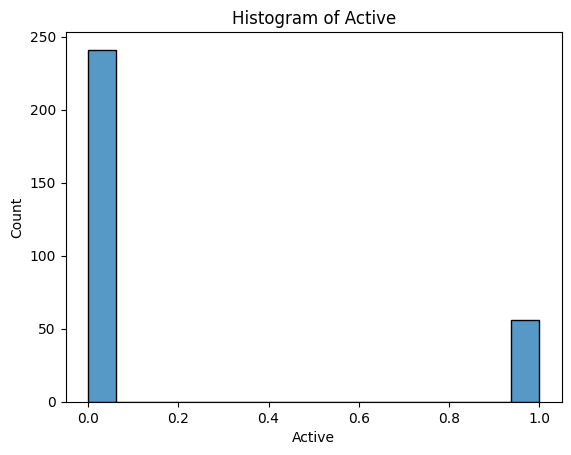

In [206]:
protac_pedia_df['Active'] = protac_pedia_df.apply(
    lambda row: is_active(row['DC50 (nM)'], row['Dmax (%)']),
    axis=1,
)

protac_pedia_df['Active'] = protac_pedia_df.apply(
    lambda row: row['Active/Inactive'] if pd.isnull(
        row['Active']) and row['Active/Inactive'] == False else row['Active'],
    axis=1,
)

print(
    f'Non-Nan Active: {len(protac_pedia_df[protac_pedia_df["Active"].notnull()])}')

# Histogram of Active
sns.histplot(data=protac_pedia_df, x='Active', bins=16)
plt.title('Histogram of Active')
plt.show()

In [ ]:
YOUR_EMAIL = "None"  # Always provide your email

def get_doi_from_pubmed(pmid: int) -> str:
    """ Get DOI from PubMed using the Entrez API.
    
    Args:
        pmid (int): PubMed ID to fetch the DOI for.
        
    Returns:
        str: DOI if available, otherwise a link to the PubMed article.
    """
    Entrez.email = YOUR_EMAIL
    handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml")
    records = Entrez.read(handle)
    handle.close()

    # Extracting DOI
    try:
        article = records['PubmedArticle'][0]
        for el in article['MedlineCitation']['Article']['ELocationID']:
            if el.attributes['EIdType'] == 'doi':
                return el
    except IndexError:
        return f'https://pubmed.ncbi.nlm.nih.gov/{pmid}/'


# Load DOI pickle
doi_file = os.path.join(data_curation_dir, 'pubmed2doi.json')
pubmed2doi = load_dict(doi_file)

# Convert PubMed IDs to string and get unique values (otherwise they'll be treated as floats)
pubmed_ids = protac_pedia_df['Pubmed'].unique().astype(str).tolist()

# Get a DOI for each PubMed ID
for pubmed_id in tqdm(pubmed_ids, desc='Getting DOIs from PubMed', total=len(pubmed_ids)):
    # print(f'Processing PubMed ID: {pubmed_id}')
    if pd.isnull(pubmed_id) or pubmed_id in {'nan', 'n/a', 'NaN', ''}:
        continue
    # Convert to int if it's a string representation of an integer
    if pubmed_id not in pubmed2doi:
        # print(f'Fetching DOI for PubMed ID: {pubmed_id}')
        pubmed2doi[pubmed_id] = get_doi_from_pubmed(int(pubmed_id))

# Save DOI
save_dict(pubmed2doi, doi_file)

Getting DOIs from PubMed: 100%|██████████| 97/97 [00:00<00:00, 952804.42it/s]


In [208]:
# Add a DOI column to the PROTAC-Pedia dataframe
protac_pedia_df['Article DOI'] = protac_pedia_df['Pubmed'].apply(
    lambda pmid: pubmed2doi.get(pmid, np.nan)
)
protac_pedia_df['Article DOI']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1197   NaN
1199   NaN
1200   NaN
1201   NaN
1202   NaN
Name: Article DOI, Length: 925, dtype: float64

For the treatment time, the maximum value is reported. Let's replace the `Treatment Time (h)` column with the maximum value:

In [209]:
def get_time(s):
    if pd.isnull(s):
        return np.nan
    return max([float(t) for t in s.split(',')])


protac_pedia_df['Treatment Time (h)'] = protac_pedia_df['Treatment Time (h)'].apply(
    get_time
)
protac_pedia_df['Treatment Time (h)'].unique().tolist()

[48.0,
 16.0,
 24.0,
 4.0,
 6.0,
 8.0,
 nan,
 12.0,
 7.0,
 20.0,
 18.0,
 2.0,
 10.0,
 96.0,
 72.0,
 5.0,
 32.0]

In [210]:
def get_inchi(s):
    if pd.isnull(s):
        return np.nan
    return Chem.MolToInchi(Chem.MolFromSmiles(s))


def get_inchi_key(s):
    if pd.isnull(s):
        return np.nan
    return Chem.MolToInchiKey(Chem.MolFromSmiles(s))


tqdm.pandas(desc='InChI')
protac_pedia_df['InChI'] = protac_pedia_df['Smiles'].progress_apply(get_inchi)
tqdm.pandas(desc='InChI Key')
protac_pedia_df['InChI Key'] = protac_pedia_df['Smiles'].progress_apply(
    get_inchi_key)

InChI Key: 100%|██████████| 925/925 [00:00<00:00, 1399.91it/s]


In [211]:
from rdkit.Chem import Descriptors, rdMolDescriptors


def get_heavy_atoms(smi):
    return Descriptors.HeavyAtomCount(Chem.MolFromSmiles(smi))


def get_ring_count(smi):
    return rdMolDescriptors.CalcNumRings(Chem.MolFromSmiles(smi))


def get_rotatable_bonds(smi):
    return rdMolDescriptors.CalcNumRotatableBonds(Chem.MolFromSmiles(smi))


def get_molecular_formula(smi):
    return rdMolDescriptors.CalcMolFormula(Chem.MolFromSmiles(smi))


protac_pedia_df['Heavy Atom Count'] = protac_pedia_df['Smiles'].apply(
    get_heavy_atoms
)
protac_pedia_df['Ring Count'] = protac_pedia_df['Smiles'].apply(
    get_ring_count
)
protac_pedia_df['Rotatable Bond Count'] = protac_pedia_df['Smiles'].apply(
    get_rotatable_bonds
)
protac_pedia_df['Molecular Formula'] = protac_pedia_df['Smiles'].apply(
    get_molecular_formula
)

In [212]:
protac_pedia_df['Database'] = 'PROTAC-Pedia'

In [213]:
ppedia_cols = [
    'Compound ID',
    # 'Target',
    'Uniprot',
    'Smiles',
    'E3 Ligase',
    'InChI',
    'InChI Key',
    'Molecular Weight',
    'Heavy Atom Count',
    'Ring Count',
    'Rotatable Bond Count',
    'Topological Polar Surface Area',
    'Hydrogen Bond Acceptor Count',
    'Hydrogen Bond Donor Count',
    'Cell Type',
    'Treatment Time (h)',
    'DC50 (nM)',
    'Dmax (%)',
    'Active',
    'Article DOI',
    'Comments',
    'Database',
    'Molecular Formula',
    'cLogP',
]

## Parse Functions per Assay Description

In [214]:
def get_assay_texts(df: pd.DataFrame, assay_column: str) -> List[str]:
    tmp = df[assay_column].dropna()
    if tmp.empty:
        return []
    return tmp.unique().tolist()


def clean_assay_text(assay):
    tmp = assay.replace('/', ' and ')
    tmp = tmp.replace('BRD4 BD1 and 2', 'BRD4 BD1 and BRD4 BD2')
    tmp = tmp.replace('(Ba and F3 WT)', '(Ba/F3 WT)')
    tmp = tmp.replace('(EGFR L858R and T790M)', '(EGFR L858R/T790M)')
    return tmp


assays = {}
for c in protac_df.columns:
    if 'Assay' in c:
        assays[c] = get_assay_texts(protac_df, c)
texts = list(set([x for y in assays.values() for x in y]))
print(len(texts))
print(sum([len(x) for x in assays.values()]))

1380
1431


In [215]:
protac_df[["Assay (Cellular activities, EC50)",
           "EC50 (nM, Cellular activities)"]].dropna(how='all').drop_duplicates()

protac_df[["Assay (Ternary complex, IC50)", "IC50 (nM, Ternary complex)"]].dropna(
    how='all').drop_duplicates()

,"Assay (Ternary complex, IC50)","IC50 (nM, Ternary complex)"
19,IC50 between VHL and the complex of protac and...,7.94
39,IC50 between VHL and the complex of protac and...,5.01
167,TR-FRET,220
168,TR-FRET/AlphaLISA,205/120
169,TR-FRET/AlphaLISA,230/330
866,IC50 between VHL and the complex of protac and...,10
1363,IC50 between VHL and the complex of protac and...,2
1699,IC50 between VHL and the complex of protac and...,6.31
1775,Titrations of PROTAC over an immobilised VCB s...,290
2453,Inhibition of CRBN in the presence of BRD4 BD1...,1800/4100


In [216]:
assay_to_parameters = {
    "Assay (DC50/Dmax)": ["DC50 (nM)", "Dmax (%)"],
    "Assay (Percent degradation)": ["Percent degradation (%)"],
    "Assay (Protac to Target, IC50)": ["IC50 (nM, Protac to Target)"],
    "Assay (Protac to Target, EC50)": ["EC50 (nM, Protac to Target)"],
    "Assay (Protac to Target, Kd)": ["Kd (nM, Protac to Target)"],
    "Assay (Protac to Target, Ki)": ["Ki (nM, Protac to Target)"],
    "Assay (Protac to Target, G/H/-TS)": ["delta G (kcal/mol, Protac to Target)", "delta H (kcal/mol, Protac to Target)", "-T*delta S (kcal/mol, Protac to Target)"],
    "Assay (Protac to Target, kon/koff/t1/2)": ["kon (1/Ms, Protac to Target)", "koff (1/s, Protac to Target)", "t1/2 (s, Protac to Target)"],
    "Assay (Protac to E3, IC50)": ["IC50 (nM, Protac to E3)"],
    "Assay (Protac to E3, EC50)": ["EC50 (nM, Protac to E3)"],
    "Assay (Protac to E3, Kd)": ["Kd (nM, Protac to E3)"],
    "Assay (Protac to E3, Ki)": ["Ki (nM, Protac to E3)"],
    "Assay (Protac to E3, G/H/-TS)": ["delta G (kcal/mol, Protac to E3)", "delta H (kcal/mol, Protac to E3)", "-T*delta S (kcal/mol, Protac to E3)"],
    "Assay (Protac to E3, kon/koff/t1/2)": ["kon (1/Ms, Protac to E3)", "koff (1/s, Protac to E3)", "t1/2 (s, Protac to E3)"],
    "Assay (Ternary complex, IC50)": ["IC50 (nM, Ternary complex)"],
    "Assay (Ternary complex, EC50)": ["EC50 (nM, Ternary complex)"],
    "Assay (Ternary complex, Kd)": ["Kd (nM, Ternary complex)"],
    "Assay (Ternary complex, Ki)": ["Ki (nM, Ternary complex)"],
    "Assay (Ternary complex, G/H/-TS)": ["delta G (kcal/mol, Ternary complex)", "delta H (kcal/mol, Ternary complex)", "-T*delta S (kcal/mol, Ternary complex)"],
    "Assay (Ternary complex, kon/koff/t1/2)": ["kon (1/Ms, Ternary complex)", "koff (1/s, Ternary complex)", "t1/2 (s, Ternary complex)"],
    "Assay (Cellular activities, IC50)": ["IC50 (nM, Cellular activities)"],
    "Assay (Cellular activities, EC50)": ["EC50 (nM, Cellular activities)"],
    "Assay (Cellular activities, GI50)": ["GI50 (nM, Cellular activities)"],
    "Assay (Cellular activities, ED50)": ["ED50 (nM, Cellular activities)"],
    "Assay (Cellular activities, GR50)": ["GR50 (nM, Cellular activities)"],
    "Assay (Permeability, PAMPA Papp)": ["PAMPA Papp (nm/s, Permeability)"],
    "Assay (Permeability, Caco-2 A2B Papp)": ["Caco-2 A2B Papp (nm/s, Permeability)"],
    "Assay (Permeability, Caco-2 B2A Papp)": ["Caco-2 B2A Papp (nm/s, Permeability)"]
}
assay_cols = []
for assay_col, param_cols in assay_to_parameters.items():
    assay_cols += param_cols + [assay_col]
non_assay_cols = list(set(protac_df) - set(assay_cols))
print(f'Non-assay columns: {non_assay_cols}')
print(f'Assay columns: {assay_cols}')

Non-assay columns: ['E3 Ligase', 'Hydrogen Bond Donor Count', 'XLogP3', 'Name', 'Heavy Atom Count', 'InChI', 'Smiles', 'PDB', 'Molecular Formula', 'Hydrogen Bond Acceptor Count', 'InChI Key', 'Article DOI', 'Rotatable Bond Count', 'Compound ID', 'Molecular Weight', 'Topological Polar Surface Area', 'Exact Mass', 'Target', 'Ring Count', 'Uniprot']
Assay columns: ['DC50 (nM)', 'Dmax (%)', 'Assay (DC50/Dmax)', 'Percent degradation (%)', 'Assay (Percent degradation)', 'IC50 (nM, Protac to Target)', 'Assay (Protac to Target, IC50)', 'EC50 (nM, Protac to Target)', 'Assay (Protac to Target, EC50)', 'Kd (nM, Protac to Target)', 'Assay (Protac to Target, Kd)', 'Ki (nM, Protac to Target)', 'Assay (Protac to Target, Ki)', 'delta G (kcal/mol, Protac to Target)', 'delta H (kcal/mol, Protac to Target)', '-T*delta S (kcal/mol, Protac to Target)', 'Assay (Protac to Target, G/H/-TS)', 'kon (1/Ms, Protac to Target)', 'koff (1/s, Protac to Target)', 't1/2 (s, Protac to Target)', 'Assay (Protac to Target,

In [217]:
for assay, cols in assay_to_parameters.items():
    tmp = protac_df[[assay] + cols].dropna(how='all').drop_duplicates()
    display(tmp.head())
    print(f'Number of (unique) rows: {len(tmp)}')
    print('-' * 80)

,Assay (DC50/Dmax),DC50 (nM),Dmax (%)
5,Degradation of WT/Exon 20 Ins EGFR in OVCAR8/H...,39.2/736.2,97.6/68.8
10,Degradation of BTK in NAMALWA cells after 24 h...,374,49
12,Degradation of BTK in K562 cells after 18 h tr...,136,88
13,Degradation of BLK in Ramos cells after 18 h t...,220,75
19,Degradation of FAK in A549 cells after 24 h tr...,158.5,NaN


Number of (unique) rows: 1648
--------------------------------------------------------------------------------


,Assay (Percent degradation),Percent degradation (%)
18,% SOS1 degradation in NCI-H358 cells after 24 ...,23.3/24.4
20,% cIAP1 degradation in MM.1S cells after 100 n...,96
21,% cIAP2 degradation in MM.1S cells after 100 n...,60
22,% XIAP degradation in MM.1S cells after 100 nM...,93
24,% HDAC8 protein degradation in A549 cells at 2...,31.3/75.3


Number of (unique) rows: 1143
--------------------------------------------------------------------------------


,"Assay (Protac to Target, IC50)","IC50 (nM, Protac to Target)"
11,Inhibition of SGK3,>10000
12,IC50 was tested by the HTRF KinEase assays,39
14,IC50 was tested by the HTRF KinEase assays,2657
15,Inhibit SIRT2 deacetylase/defatty-acylase,69/170
19,IC50 was assessed by FRET,1


Number of (unique) rows: 1149
--------------------------------------------------------------------------------


,"Assay (Protac to Target, EC50)","EC50 (nM, Protac to Target)"
2464,EC50 of BRD4 BD1/2 was tested by TR-FRET,95/298
7021,EC50 was tested by TR-FRET coactivator assays,31
7539,Binding of c-Src,45
7541,Binding of c-Src,1500


Number of (unique) rows: 4
--------------------------------------------------------------------------------


,"Assay (Protac to Target, Kd)","Kd (nM, Protac to Target)"
1,ITC,15
26,Binding capacity to AURKA,41000
140,ITC,8.8
154,SPR,550
167,SPR in PBRM1 BD5,2700


Number of (unique) rows: 257
--------------------------------------------------------------------------------


,"Assay (Protac to Target, Ki)","Ki (nM, Protac to Target)"
6,NaN,SPR
1180,FP,37.27
1307,MDM2-P53 competitive binding activities were t...,10000
1331,Ki was assessed using a radio-ligand displacem...,5
2409,Binding affinity of BRD3 BD1,7.28


Number of (unique) rows: 152
--------------------------------------------------------------------------------


,"Assay (Protac to Target, G/H/-TS)","delta G (kcal/mol, Protac to Target)","delta H (kcal/mol, Protac to Target)","-T*delta S (kcal/mol, Protac to Target)"
1,ITC,-10.7,-12.5,1.8
140,ITC,-11,-11.4,0.44
531,ITC,-11.35,-12.8,1.485
1810,ITC in BRD2 BD1,-9.57,-13.7,4.2
1812,ITC in BRD4 BD2,-10.3,-10.4,0.1


Number of (unique) rows: 26
--------------------------------------------------------------------------------


,"Assay (Protac to Target, kon/koff/t1/2)","kon (1/Ms, Protac to Target)","koff (1/s, Protac to Target)","t1/2 (s, Protac to Target)"
746,SPR,490000.0,0.015,NaN
2810,NaN,1.4,0.770,NaN
5311,NaN,1.8,0.400,NaN
8462,BLI,68900.0,0.042,16.0


Number of (unique) rows: 4
--------------------------------------------------------------------------------


,"Assay (Protac to E3, IC50)","IC50 (nM, Protac to E3)"
19,FP,501.2
32,Inhibition of VHL by competition binding assay,656
39,FP,316.2
119,FP,383
174,IC50 was tested using BRD4 BRD2-eGFP-mCherry r...,72.8


Number of (unique) rows: 167
--------------------------------------------------------------------------------


,"Assay (Protac to E3, EC50)","EC50 (nM, Protac to E3)"
261,TR-FRET,590.0
407,TR-FRET,1000.0
442,TR-FRET,2560.0
510,TR-FRET,1790.0
3415,EC50 was tested using a BRD4 BRD2-eGFP-mCherry...,641.0


Number of (unique) rows: 9
--------------------------------------------------------------------------------


,"Assay (Protac to E3, Kd)","Kd (nM, Protac to E3)"
1,ITC/FP,33/24
140,ITC/FP,87/70
154,SPR,3500
167,ITC/SPR,234/98
531,ITC/FP,26/35


Number of (unique) rows: 68
--------------------------------------------------------------------------------


,"Assay (Protac to E3, Ki)","Ki (nM, Protac to E3)"
167,FP,210.0
1825,FP,77.0
1828,FP,72.0
3755,FP,490.0
3759,FP,450.0


Number of (unique) rows: 7
--------------------------------------------------------------------------------


,"Assay (Protac to E3, G/H/-TS)","delta G (kcal/mol, Protac to E3)","delta H (kcal/mol, Protac to E3)","-T*delta S (kcal/mol, Protac to E3)"
1,ITC,-10.20,-15.20,4.9
140,ITC,-9.64,-6.56,-3.1
167,ITC,-37.90,-21.00,-17.0
531,ITC,-10.40,-7.04,-3.4
1810,ITC,-9.01,-7.90,-1.1


Number of (unique) rows: 18
--------------------------------------------------------------------------------


,"Assay (Protac to E3, kon/koff/t1/2)","kon (1/Ms, Protac to E3)","koff (1/s, Protac to E3)","t1/2 (s, Protac to E3)"
1403,NaN,NaN,NaN,22.9
1828,SPR,700000.0,0.019,43.0
2276,SPR,600000.0,0.060,17.0
2442,SPR,270000.0,0.015,48.0


Number of (unique) rows: 4
--------------------------------------------------------------------------------


,"Assay (Ternary complex, IC50)","IC50 (nM, Ternary complex)"
19,IC50 between VHL and the complex of protac and...,7.94
39,IC50 between VHL and the complex of protac and...,5.01
167,TR-FRET,220
168,TR-FRET/AlphaLISA,205/120
169,TR-FRET/AlphaLISA,230/330


Number of (unique) rows: 23
--------------------------------------------------------------------------------


,"Assay (Ternary complex, EC50)","EC50 (nM, Ternary complex)"
8534,ELISA,8.0


Number of (unique) rows: 1
--------------------------------------------------------------------------------


,"Assay (Ternary complex, Kd)","Kd (nM, Ternary complex)"
1,ITC/FP,73/98
6,162,NaN
102,178,NaN
140,ITC/FP,83/60
154,SPR,436


Number of (unique) rows: 79
--------------------------------------------------------------------------------


,"Assay (Ternary complex, Ki)","Ki (nM, Ternary complex)"
167,FP,79
168,FP,48
169,FP,26
815,FRET-based competition assay,64.8
1265,FRET-based competition assay,57.7


Number of (unique) rows: 13
--------------------------------------------------------------------------------


,"Assay (Ternary complex, G/H/-TS)","delta G (kcal/mol, Ternary complex)","delta H (kcal/mol, Ternary complex)","-T*delta S (kcal/mol, Ternary complex)"
1,ITC between VHL and BRD9-BD:PROTAC,-9.7,-6.4,-3.3
168,ITC between VHL and PROTAC:SMARCA2,-41.8,-27,-15
531,ITC between VHL and BRD9-BD:PROTAC,-10.33,-5.1,-5.3
1810,ITC between VHL and BRD2 BD1:PROTAC,-9.85,-9.17,-0.6
1812,ITC between VHL and BRD4 BD2:PROTAC,-10.13,-10.9,-0.6


Number of (unique) rows: 25
--------------------------------------------------------------------------------


,"Assay (Ternary complex, kon/koff/t1/2)","kon (1/Ms, Ternary complex)","koff (1/s, Ternary complex)","t1/2 (s, Ternary complex)"
6,NaN,NaN,NaN,24.1
102,NaN,NaN,NaN,19.8
154,SPR,39600,0.018,38
1403,NaN,NaN,NaN,3.7
1404,NaN,NaN,NaN,55.9


Number of (unique) rows: 29
--------------------------------------------------------------------------------


,"Assay (Cellular activities, IC50)","IC50 (nM, Cellular activities)"
4,Inhibit proliferation of SKBr3 cells,102
9,Inhibit viability of MOLT-4 cells,97
23,Inhibition of cell proliferation of A2780 cells,1227
25,Inhibit proliferation of PC-3/LNCaP/22Rv1 cells,2340/2370/4940
26,Inhibit cell proliferation of KG1A/Kasumi-1 cells,9230/3750


Number of (unique) rows: 1658
--------------------------------------------------------------------------------


,"Assay (Cellular activities, EC50)","EC50 (nM, Cellular activities)"
43,Inhibit proliferation of EOL-1/A-402 cells,35/305
180,Inhibit proliferation of GIST-T1/Kasumi 1 cells,326.4/1873
285,Dephosphorylation of Rab10 in WT LRRK2 MEFs,2270
286,Dephosphorylation of Rab10 in G2019S LRRK2 MEFs,379
400,Inhibit proliferation of T790M/L858R transform...,<500


Number of (unique) rows: 152
--------------------------------------------------------------------------------


,"Assay (Cellular activities, GI50)","GI50 (nM, Cellular activities)"
736,Inhibit proliferation of HCC-827 cells,770
793,Inhibit proliferation of Karpas422/G401 cells,57/620
1965,Inhibit viability of HBL-1/RAMOS cells,>200/>1000
1966,Inhibit viability of HBL-1 cells expressing BT...,28.8
1967,Inhibit viability of HBL-1/RAMOS cells,1.5/>1000


Number of (unique) rows: 98
--------------------------------------------------------------------------------


,"Assay (Cellular activities, ED50)","ED50 (nM, Cellular activities)"
3054,Inhibit proliferation of TMD8/Maver-1/Granta-5...,44.3/193/203
3055,Inhibit proliferation of TMD8 cells with C481S...,149
3490,Inhibit proliferation of Mino cells,69
3763,Inhibit proliferation of Mino/TMD8/Maver-1 cells,12/29.2/47.7
3764,Inhibit proliferation of TMD8 cells with C481S...,128


Number of (unique) rows: 5
--------------------------------------------------------------------------------


,"Assay (Cellular activities, GR50)","GR50 (nM, Cellular activities)"
342,Inhibit growth of OVCAR8 cells,33.1
727,13b,NaN
748,12a(WWL0245),NaN
1346,Inhibit proliferation of ZR-75-1/T47D/LNCaP cells,16/178/130
1469,11h,NaN


Number of (unique) rows: 20
--------------------------------------------------------------------------------


,"Assay (Permeability, PAMPA Papp)","PAMPA Papp (nm/s, Permeability)"
139,Compounds were administered at 10000 nM and in...,0.01
184,Compounds were administered at 10000 nM and in...,<1
422,Compounds were administered at 10000 nM and in...,0.02
1148,parallel artificial membrane permeability assay,<0.005
1816,PAMPA assay,0.01


Number of (unique) rows: 18
--------------------------------------------------------------------------------


,"Assay (Permeability, Caco-2 A2B Papp)","Caco-2 A2B Papp (nm/s, Permeability)"
114,Compounds were administered at 10000 nM and in...,<1
1206,Compounds were administered at 10000 nM and in...,0.37
1711,Caco-2 A2B assay,0.04
1712,Caco-2 A2B assay,0.08
1746,Compounds were administered at 10000 nM and in...,<0.69


Number of (unique) rows: 39
--------------------------------------------------------------------------------


,"Assay (Permeability, Caco-2 B2A Papp)","Caco-2 B2A Papp (nm/s, Permeability)"
114,Compounds were administered at 10000 nM and in...,11
1206,Compounds were administered at 10000 nM and in...,12.84
1711,Caco-2 B2A assay,5.5
1712,Caco-2 B2A assay,1.8
1746,Compounds were administered at 10000 nM and in...,8.6


Number of (unique) rows: 30
--------------------------------------------------------------------------------


### DC50 and Dmax

In [218]:
def extract_dc50_info(sentence):
    # Regex patterns for proteins/genes, cell types, and treatment hours
    protein_regex = r"Degradation of total\s(.+?)\s(in|after|using|proteins)"
    cell_regex = r"in\s([A-Za-z0-9-/.;\(\)\s\+]+)\scells"
    treatment_regex = r"after\s(\d+/?\d*?/?\d*?\s?h)"

    # Extracting protein information
    if 'total' in sentence.lower():
        protein_match = re.search(protein_regex, sentence)
        proteins = protein_match.group(1).split(' and ') if protein_match else [
            re.search(r"Degradation of\s([A-Za-z0-9-]+)", sentence).group(1)]
    else:
        if ' in ' in sentence.lower():
            proteins = sentence.split(' in ')[0].split('Degradation of ')[-1]
            proteins = proteins.split('/') if '/' in proteins else [proteins]
        else:
            protein_match = re.search(protein_regex, sentence)
            proteins = protein_match.group(1).split(
                '/') if protein_match else [re.search(r"Degradation of\s([A-Za-z0-9-\/]+)", sentence).group(1)]
    # Handle special cases...
    if 'BRD4 short/long' in sentence:
        proteins = ['BRD4 short', 'BRD4 long']
    if 'BRD4 BD1/2' in sentence:
        proteins = ['BRD4 BD1', 'BRD4 BD2']
    elif 'BRD4 BD1' in sentence:
        proteins = ['BRD4 BD1']
    if 'EGFR L858R/T790M' in sentence:
        proteins = ['EGFR L858R/T790M']
    if 'EGFR del19/T790M/C797S' in sentence:
        proteins = ['EGFR del19/T790M/C797S']

    # Extracting cell types
    cell_match = re.search(cell_regex, sentence)
    cells = cell_match.group(1).split('/') if cell_match else np.nan
    # Handle special cases...
    if 'Ba/F3' in sentence:
        # Replace any occurences that contain 'Ba' or 'F3' with 'Ba/F3' and remove duplicates while preserving the order in the other cells
        cells = ['Ba/F3' if 'Ba' in c or 'F3' in c else c for c in cells]
        cells.pop(cells.index('Ba/F3'))
    if 'ER-positive breast cancer cell lines' in sentence:
        cells = ['ER-positive breast cancer cell lines']
    if 'LNCaP (AR T878A)' in sentence:
        cells = ['LNCaP']
    if 'in A152T neurons' in sentence:
        cells = ['A152T neurons']
    if 'of Rpn13 in MM.1S after' in sentence:
        cells = ['MM.1S']
    if 'Primary Cardiomyocytes' in sentence:
        cells = ['Primary Cardiomyocytes']
    if ' HDAC6 in MM1S after' in sentence:
        cells = ['MM.1S']

    # Extracting treatment hours
    treatment_hours_match = re.search(treatment_regex, sentence)
    if treatment_hours_match:
        treatment_hours = treatment_hours_match.group(1).strip('h')
        treatment_hours = split_clean_str(treatment_hours, return_floats=True)
    else:
        treatment_hours = np.nan

    return {
        'Target (Parsed)': proteins,
        'Cell Type': cells,
        'Treatment Time (h)': treatment_hours,
    }


corner_cases = [
    # 'Degradation of BRD4',
    # 'Degradation of BRD4 short/long in HeLa cells after 24 h treatment',
    # 'Degradation of BRD4 BD1 assessed by EGFP/mCherry reporter assay',
    # 'Degradation of BRD4 BD1/2 assessed by EGFP/mCherry reporter assay',
    # 'Degradation of WT/Exon 20 Ins EGFR in OVCAR8/HeLa cells after 24 h treatment',
    # 'Degradation of TPM3-TRKA/TRKA in KM12/HEL cells after 6 h treatment',
    # 'Degradation of Exon 19 del/L858R EGFR in HCC827/H3255 cells after 24 h treatment',
    # 'Degradation of NPM-ALK/EML4-ALK in SU-DHL-1/NCI-H2228 cells after 16 h treatment',
    # 'Degradation of BCR-ABL T315I in Ba/F3 cells after 24 h treatment',
    # 'Degradation of BCR-ABL T315I in MOL/(Ba/F3)/R4;11 cells after 24 h treatment',
    # 'Degradation of ALK in H3122/Karpas 299/Kelly cells 16 h treatment',
    'Degradation of AR in LNCaP/VCaP AR+ cells after 6 h treatment',
    'Degradation of BRD4 BD1/2 assessed by EGFP/mCherry reporter assay',
    'Degradation of BRD4 BD1 assessed by EGFP/mCherry reporter assay',
    'Degradation of PARP1 in Primary Cardiomyocytes after 24 h treatment',
    'Degradation of HDAC6 in MM1S after 6 h treatment by in-cell ELISA analysis',
    'Degradation of total tau/P-tau in A152T neurons after 24 h treatment',
    'Degradation of Rpn13 in MM.1S after 16 h treatment',
    'Degradation of HDAC6 in MM1S after 6 h treatment by in-cell ELISA analysis',
]

for assay in assays["Assay (DC50/Dmax)"][-5:] + corner_cases:
    if len(assay) < 5:
        continue
    print(assay)
    extracted_info = extract_dc50_info(assay)
    proteins, cells, treatment_hours = extracted_info[
        'Target (Parsed)'], extracted_info['Cell Type'], extracted_info['Treatment Time (h)']
    print(proteins, "|", cells, "|", treatment_hours)
    print('-' * 80)

Degradation of SMARCA4 in SW1573 cells after 22h treatment
['SMARCA4'] | ['SW1573'] | [22.0]
--------------------------------------------------------------------------------
Degradation of SOS1 in H358 cells after 6h treatment
['SOS1'] | ['H358'] | [6.0]
--------------------------------------------------------------------------------
Degradation of HPGDS in KU812 cells after 6/24 h treatment
['HPGDS'] | ['KU812'] | [6.0, 24.0]
--------------------------------------------------------------------------------
Degradation of H-PGDS in KU182 cells after 24h treatment
['H-PGDS'] | ['KU182'] | [24.0]
--------------------------------------------------------------------------------
Degradation of IRE1alpha in HEK293T cells after 24h treatment
['IRE1alpha'] | ['HEK293T'] | [24.0]
--------------------------------------------------------------------------------
Degradation of AR in LNCaP/VCaP AR+ cells after 6 h treatment
['AR'] | ['LNCaP', 'VCaP AR+'] | [6.0]
-------------------------------------

Let's first remove all entries with _all_ missing values in the `DC50 (nM)`, `Dmax (%)`, and `Assay (DC50/Dmax)` columns:

In [219]:
param_cols = assay_to_parameters["Assay (DC50/Dmax)"]

if not SKIP_SCRAPED_DF:
    dc50_dmax_df = pd.concat([protac_df, scraped_protac_df]).dropna(
        subset=param_cols + ["Assay (DC50/Dmax)"], how='all')
else:
    dc50_dmax_df = protac_df.dropna(
        subset=param_cols + ["Assay (DC50/Dmax)"], how='all')
dc50_dmax_df = dc50_dmax_df[dc50_dmax_df["Assay (DC50/Dmax)"].notnull()]

# Drop all "assay columns" in assay_to_parameters except for "Assay (DC50/Dmax)" and its parameters
dc50_dmax_df = dc50_dmax_df.drop(
    columns=[col for col in assay_cols if col not in param_cols + ["Assay (DC50/Dmax)"]])
dc50_dmax_df = dc50_dmax_df.drop_duplicates()
len(dc50_dmax_df)

1892

In [220]:
parsed_table = []

for i, row in tqdm(dc50_dmax_df.iterrows(), total=len(dc50_dmax_df), desc='Extracting DC50/Dmax info'):
    assay = row["Assay (DC50/Dmax)"]
    if len(assay) < 5:
        continue
    extracted_info = extract_dc50_info(assay)
    extracted_info['DC50 (nM)'] = split_clean_str(
        row['DC50 (nM)'], return_floats=True)
    extracted_info['Dmax (%)'] = split_clean_str(
        row['Dmax (%)'], return_floats=True)

    # Get the max len of each list in the extracted info
    max_len = max([len(v)
                  for v in extracted_info.values() if isinstance(v, list)])
    for i in range(max_len):
        row_tmp = row.copy().to_dict()
        row_tmp.update({k: v[i % len(v)] if isinstance(v, list)
                       else v for k, v in extracted_info.items()})
        parsed_table.append(row_tmp)

parsed_table = pd.DataFrame(parsed_table)
display(parsed_table.head())
print(f'Parsed table len: {len(parsed_table)}')

Extracting DC50/Dmax info: 100%|██████████| 1892/1892 [00:00<00:00, 19503.55it/s]


,Compound ID,Uniprot,Target,E3 Ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,Target (Parsed),Cell Type,Treatment Time (h)
0,275,P00533,EGFR,VHL,NaN,NaN,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,39.2,97.6,Degradation of WT/Exon 20 Ins EGFR in OVCAR8/H...,...,13,4,21,186.36,C55H57ClFN7O8S,InChI=1S/C55H57ClFN7O8S/c1-34-50(73-33-61-34)3...,ZSCOIFSUFMYZEZ-YSWDPXALSA-N,WT,OVCAR8,24.0
1,275,P00533,EGFR,VHL,NaN,NaN,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,736.2,68.8,Degradation of WT/Exon 20 Ins EGFR in OVCAR8/H...,...,13,4,21,186.36,C55H57ClFN7O8S,InChI=1S/C55H57ClFN7O8S/c1-34-50(73-33-61-34)3...,ZSCOIFSUFMYZEZ-YSWDPXALSA-N,Exon 20 Ins EGFR,HeLa,24.0
2,750,Q06187,BTK,VHL,NaN,SJF638,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,374.0,49.0,Degradation of BTK in NAMALWA cells after 24 h...,...,15,4,18,212.18,C50H60N10O7S,InChI=1S/C50H60N10O7S/c1-32-44(68-31-55-32)35-...,RIOHYDUGYNZWPD-DIKPJKDTSA-N,BTK,NAMALWA,24.0
3,1373,Q06187,BTK,VHL,NaN,NaN,C=CC(=O)N1C[C@@H](N2N=C(C3=CC=C(OC4=CC=CC=C4)C...,136.0,88.0,Degradation of BTK in K562 cells after 18 h tr...,...,17,4,20,255.55,C53H60N10O10S,InChI=1S/C53H60N10O10S/c1-6-43(66)61-27-36(63-...,JQIURFOHEWHROK-WNKYWPOYSA-N,BTK,K562,18.0
4,1373,P51451,BLK,VHL,NaN,NaN,C=CC(=O)N1C[C@@H](N2N=C(C3=CC=C(OC4=CC=CC=C4)C...,220.0,75.0,Degradation of BLK in Ramos cells after 18 h t...,...,17,4,20,255.55,C53H60N10O10S,InChI=1S/C53H60N10O10S/c1-6-43(66)61-27-36(63-...,JQIURFOHEWHROK-WNKYWPOYSA-N,BLK,Ramos,18.0


Parsed table len: 2264


In [221]:
parsed_table[parsed_table['Target'] !=
             parsed_table['Target (Parsed)']][['Assay (DC50/Dmax)', 'Target', 'Target (Parsed)']].drop_duplicates()

,Assay (DC50/Dmax),Target,Target (Parsed)
0,Degradation of WT/Exon 20 Ins EGFR in OVCAR8/H...,EGFR,WT
1,Degradation of WT/Exon 20 Ins EGFR in OVCAR8/H...,EGFR,Exon 20 Ins EGFR
15,Degradation of C481S BTK in XLA cells after 24...,BTK C481S,C481S BTK
27,Degradation of Fak in A549/Hep3B2.1-7/SNU-387 ...,FAK,Fak
30,Degradation of Fak in HLE/HuH-7/SNU-423 cells ...,FAK,Fak
...,...,...,...
2142,Degradation of G2019S LRRK2 in MEFs after 4 h ...,LRRK2 G2019S,G2019S LRRK2
2175,Degradation of ERK1/2 in A375 cells after 48 h...,ERK1,2
2183,Degradation of ERK1/2 in HCT116/Calu-6 cells a...,ERK1,2
2184,Degradation of TC-PTP in HEK293 cells after 16...,PTPN2,TC-PTP


Non-Nan Active: 1702


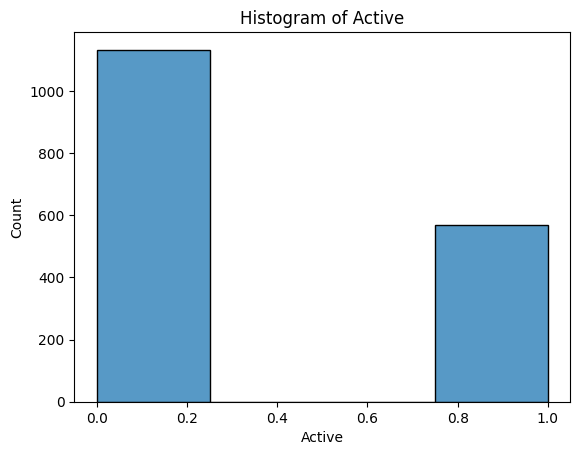

In [222]:
parsed_table['Active'] = parsed_table.apply(
    lambda row: is_active(row['DC50 (nM)'], row['Dmax (%)']),
    axis=1,
)

print(f'Non-Nan Active: {len(parsed_table[parsed_table["Active"].notnull()])}')

# Histogram of Active
sns.histplot(data=parsed_table, x='Active', bins=4)
plt.title('Histogram of Active')
plt.show()

In [223]:
parsed_table['Database'] = 'PROTAC-DB'

## Merge Parsed DataFrames

In [224]:
merged_df = pd.concat([protac_pedia_df[ppedia_cols],
                       parsed_table], ignore_index=True)
merged_df

,Compound ID,Uniprot,Smiles,E3 Ligase,InChI,InChI Key,Molecular Weight,Heavy Atom Count,Ring Count,Rotatable Bond Count,...,Database,Molecular Formula,cLogP,Target,PDB,Name,Assay (DC50/Dmax),Exact Mass,XLogP3,Target (Parsed)
0,1,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C73H88ClF3N10O10S4/c1-47(49-13-15-51(...,SXPDUCVNMGMWBJ-FMZBIETASA-N,1486.282,101,10,24,...,PROTAC-Pedia,C73H88ClF3N10O10S4,10.83732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C74H90ClF3N10O10S4/c1-48(50-13-15-52(...,HQKUMELJMUNTTF-NMKDNUEVSA-N,1500.309,102,10,25,...,PROTAC-Pedia,C74H90ClF3N10O10S4,11.22742,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C75H92ClF3N10O10S4/c1-49(51-16-18-53(...,ATQCEJKUPSBDMA-QARNUTPLSA-N,1514.336,103,10,26,...,PROTAC-Pedia,C75H92ClF3N10O10S4,11.61752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C76H94ClF3N10O10S4/c1-50(52-17-19-54(...,FNKQAGMHNFFSEI-DTTPTBRMSA-N,1528.363,104,10,27,...,PROTAC-Pedia,C76H94ClF3N10O10S4,12.00762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C77H96ClF3N10O10S4/c1-51(53-18-20-55(...,PXVFFBGSTYQHRO-REQIQPEASA-N,1542.390,105,10,28,...,PROTAC-Pedia,C77H96ClF3N10O10S4,12.39772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,4110,O60760,CN1C=CC=C1C(=O)N1CCN(C(=O)NC2=CC=C(N3CCC(C(=O)...,CRBN,InChI=1S/C40H45N9O7/c1-43-15-3-6-32(43)38(54)4...,BNWOEWUWHFLSPN-UHFFFAOYSA-N,763.856,56,8,6,...,PROTAC-DB,C40H45N9O7,NaN,HPGDS,NaN,PROTAC(H-PGDS)-4-TAS-205,Degradation of H-PGDS in KU182 cells after 24h...,763.344195,0.99,H-PGDS
3185,4111,O60760,CN1C=CC=C1C(=O)N1CCN(C(=O)NC2=CC=C(N3CCC(C(=O)...,CRBN,InChI=1S/C40H45N9O7/c1-43-14-2-3-33(43)39(55)4...,VRNMALHFNHEWOB-UHFFFAOYSA-N,763.856,56,8,6,...,PROTAC-DB,C40H45N9O7,NaN,HPGDS,NaN,PROTAC(H-PGDS)-5-TAS-205,Degradation of H-PGDS in KU182 cells after 24h...,763.344195,0.99,H-PGDS
3186,4113,O60760,O=C1CCC(N2C(=O)C3=CC(F)=C(N4CCN(C(=O)C5CCN(C6=...,CRBN,InChI=1S/C40H37FN8O7/c41-31-20-29-30(39(55)49(...,WUKCZLQLSCQODB-UHFFFAOYSA-N,760.783,56,8,8,...,PROTAC-DB,C40H37FN8O7,NaN,HPGDS,NaN,NaN,Degradation of H-PGDS in KU812 cells after 24h...,760.276924,2.87,H-PGDS
3187,4114,Q9C5S2,CC1=C(CC(=O)N2CCC(C3=CC=C(NC4CCC(=O)NC4=O)C=C3...,CRBN,InChI=1S/C29H29N3O7/c1-16-20-6-8-24(34)22(15-3...,JUIHFQABBIMEAQ-UHFFFAOYSA-N,531.565,39,5,6,...,PROTAC-DB,C29H29N3O7,NaN,IRE1alpha,NaN,CPD-2828,Degradation of IRE1alpha in HEK293T cells afte...,531.200550,2.34,IRE1alpha


In [225]:
merged_df[merged_df['Target'].str.contains(
    'BCR') | merged_df['Target'].str.contains('ABL')][['Uniprot', 'Target', 'Target (Parsed)', 'Article DOI']].drop_duplicates()

,Uniprot,Target,Target (Parsed),Article DOI
982,NaN,BCR-ABL,BCR-ABL,10.1111/cas.13284
1045,NaN,BCR-ABL,BCR-ABL,10.1021/acs.jmedchem.9b01264
1050,NaN,BCR-ABL,BCR-ABL,10.1016/j.ejmech.2021.113645
1347,NaN,BCR-ABL,BCR-ABL,10.1039/d0cc02201b
1508,NaN,BCR-ABL T315I,BCR-ABL T315I,10.1016/j.apsb.2020.11.009
1618,NaN,BCR-ABL,BCR-ABL,10.1021/acs.jmedchem.0c00967
1866,NaN,BCR-ABL,BCR-ABL,10.1158/0008-5472.CAN-19-1236
2061,NaN,BCR-ABL,BCR-ABL,10.1021/acs.jmedchem.9b02058
3026,NaN,BCR-ABL,BCR-ABL,10.1016/j.ejmech.2022.114810


In [226]:
target2uniprot = {
    'BCR-ABL': 'P00520',
    'BCR-ABL T315I': 'P00520',
    'NS3': 'A8DG50',
    'HSP90': 'P07900',
}
# Fill in Uniprot column based on Target column if Uniprot is NaN
merged_df['Uniprot'] = merged_df.apply(
    lambda row: target2uniprot.get(row['Target'], row['Uniprot']), axis=1)

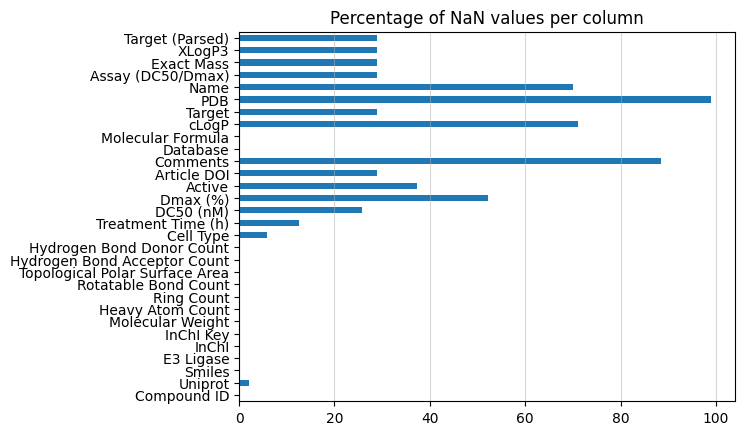

In [227]:
# Print NaN percentage per column
tmp = merged_df.isna().sum() / len(merged_df) * 100
# Plot tmp as a horizontal bar plot
tmp.plot(kind='barh')
plt.title('Percentage of NaN values per column')
plt.grid(axis='x', alpha=0.5)
plt.show()

# plt.figure(figsize=(10, 5))
# sns.barplot(x=tmp.index, y=tmp.values)
# plt.xticks(rotation=90)
# plt.title('NaN percentage per column')
# plt.grid(axis='y', alpha=0.5)
# plt.show()

In [228]:
# List the Nan cell types in merged_df
merged_df[merged_df['Cell Type'].isna()][['Compound ID', 'Target', 'Cell Type', 'Assay (DC50/Dmax)']]

,Compound ID,Target,Cell Type,Assay (DC50/Dmax)
227,250,NaN,NaN,NaN
229,252,NaN,NaN,NaN
230,253,NaN,NaN,NaN
231,254,NaN,NaN,NaN
232,255,NaN,NaN,NaN
...,...,...,...,...
2655,3540,SMARCA4,NaN,Degradation of SMARCA4 proteins by the HiBit d...
3066,5215,LRRK2,NaN,Degradation of LRRK2 in MEFs after 4 h treatment
3067,5215,LRRK2 G2019S,NaN,Degradation of G2019S LRRK2 in MEFs after 4 h ...
3068,5216,LRRK2,NaN,Degradation of LRRK2 in MEFs after 4 h treatment


In [229]:
for c in merged_df.columns:
    num_nulls = merged_df[c].isnull().sum()
    if num_nulls:
        print(f'Empty "{c}" values: {num_nulls}')
        print(merged_df[merged_df[c].isnull()]['Database'].value_counts())
        print('-' * 80)

Empty "Uniprot" values: 65
Database
PROTAC-DB    65
Name: count, dtype: int64
--------------------------------------------------------------------------------
Empty "Cell Type" values: 188
Database
PROTAC-DB       113
PROTAC-Pedia     75
Name: count, dtype: int64
--------------------------------------------------------------------------------
Empty "Treatment Time (h)" values: 399
Database
PROTAC-DB       284
PROTAC-Pedia    115
Name: count, dtype: int64
--------------------------------------------------------------------------------
Empty "DC50 (nM)" values: 824
Database
PROTAC-Pedia    703
PROTAC-DB       121
Name: count, dtype: int64
--------------------------------------------------------------------------------
Empty "Dmax (%)" values: 1662
Database
PROTAC-DB       1035
PROTAC-Pedia     627
Name: count, dtype: int64
--------------------------------------------------------------------------------
Empty "Active" values: 1190
Database
PROTAC-Pedia    628
PROTAC-DB       562
Name: cou

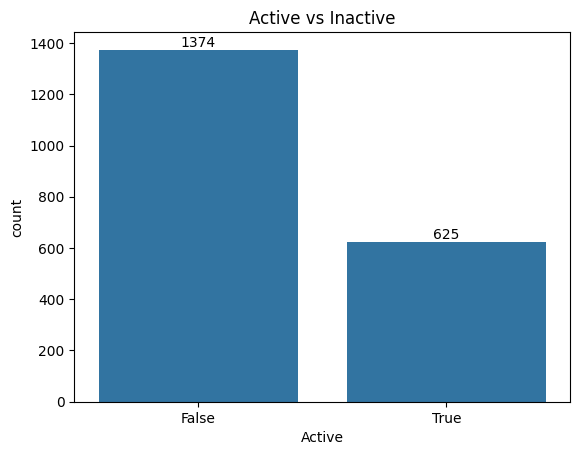

In [230]:
# Plot active vs inactive in merged_df
sns.countplot(data=merged_df, x='Active')
# Put the number of active and inactive on top of the bars
for i, count in enumerate(merged_df['Active'].value_counts()):
    plt.text(i, count, count, ha='center', va='bottom')
plt.title('Active vs Inactive')
plt.show()

In [231]:
merged_df[merged_df['Uniprot'].isnull()]['Target'].unique().tolist()

['Alpha-tubulin',
 'Beta3-tubulin',
 'BRD4-L',
 'EML4-ALK',
 'EML4-ALK G1202R',
 'EML4-ALK C1156Y',
 'EML4-ALK L1196M',
 'EML4-ALK L1196M/G1202R',
 'c-Src',
 'p-p38']

In [232]:
merged_df[merged_df['Uniprot'].isnull() & merged_df['Target'].str.contains(
    'FGFR3_HUMAN-TACC3_HUMAN')]['Article DOI'].unique().tolist()

[]

In [233]:
merged_df[merged_df['Uniprot'] == 'FGFR3_HUMAN-TACC3_HUMAN']

,Compound ID,Uniprot,Smiles,E3 Ligase,InChI,InChI Key,Molecular Weight,Heavy Atom Count,Ring Count,Rotatable Bond Count,...,Database,Molecular Formula,cLogP,Target,PDB,Name,Assay (DC50/Dmax),Exact Mass,XLogP3,Target (Parsed)


In [234]:
def canonize_smiles(smi):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smi))


merged_df['Smiles'] = merged_df['Smiles'].apply(canonize_smiles)

Remove duplicates in UniProt ID column, _i.e._, keep the first entry:

In [ ]:
def clean_uniprot(uniprot):
    if pd.isnull(uniprot) or uniprot in {'nan', 'n/a', 'NaN', ''}:
        return np.nan
    return uniprot.split(',')[0].strip() if ',' in uniprot else uniprot.strip()

merged_df['Uniprot'] = merged_df['Uniprot'].apply(clean_uniprot)

### Get Amino Acid Sequence

Scrape FASTA sequence from UniProt database.

NOTE: The Uniprot ID can be referring to both E3 and POI target, but we assume it's referring to the POI target.

In [236]:
poi_sequences_file = os.path.join(data_curation_dir, 'poi_uniprot2sequence.json')
uniprot2sequence = load_dict(poi_sequences_file)

for uniprot in tqdm(merged_df['Uniprot'].unique().tolist(), desc='Web-scraping sequences'):
    if uniprot in uniprot2sequence:
        continue
    try:
        baseUrl = 'http://www.uniprot.org/uniprot/'
        currentUrl = baseUrl + uniprot + '.fasta'
        response = requests.post(currentUrl)
        cData = ''.join(response.text)
        i = cData.index('\n') + 1
        seq = cData[i:].rstrip().replace('\n', '')
        uniprot2sequence[uniprot] = seq
    except Exception as e:
        print(f'Exception: {e}')
        print(f'Exception: Error getting {uniprot} from URL: {currentUrl}')
        print(f'Exception: Setting sequence for {uniprot} to NaN')
        uniprot2sequence[uniprot] = float('nan')

# Save the uniprot2sequence dictionary to a JSON file
save_dict(uniprot2sequence, poi_sequences_file)

# Add 'Unknown' sequences corresponding to 'Unknown' genes/POIs
uniprot2sequence['Unknown'] = float('nan')
sequence2uniprot = {v: k for k, v in uniprot2sequence.items()}

Web-scraping sequences: 100%|██████████| 160/160 [00:00<00:00, 2052258.84it/s]

Exception: can only concatenate str (not "float") to str
Exception: Error getting nan from URL: http://www.uniprot.org/uniprot/Q9NXF7.fasta
Exception: Setting sequence for nan to NaN


In [237]:
merged_df['POI Sequence'] = merged_df['Uniprot'].map(uniprot2sequence)

#### Applying Gene Mutations

AR-V7, for instance, has different "splicing variance", meaning that the aminoacid sequence might be "very" dfferent, _i.e._ instead of differ by just one or a few letters, they might instead have entire different "chucks" of letters.

NOTE: Indexing starts from one! Not zero!

In [238]:
def apply_mutation(uniprot: str, gene: str, seq: str, on_error: Literal['raise', 'ignore'] = 'raise') -> str:
    """Apply the mutation to the sequence, if possible."""
    # Check if both gene and sequence are not nan
    if pd.isna(gene) or pd.isna(seq) or gene.startswith('BRD') or len(gene.split(' ')) == 1:
        return seq
    # TODO: Just use a dictionary and replace these sequences straightaway...
    uniprot_exceptions = {
        ('O60885', 'BRD4 BD1'): uniprot2sequence['O60885'],
        ('P25440', 'BRD2 BD2'): uniprot2sequence['P25440'],
        ('P10275', 'AR-V7'): uniprot2sequence['P10275'],
        # TODO: Not working... why???
        ('P00533', 'EGFR e19d'): uniprot2sequence['P10275'],
    }
    # Handle exceptions
    if (uniprot, gene) in uniprot_exceptions:
        return uniprot_exceptions[(uniprot, gene)]
    original_seq = seq
    mutation = gene.split(' ')[1]
    operations = mutation.split('/') if '/' in mutation else [mutation]
    del_ops = 0
    # print(
    #     f'Applying mutation {mutation} from gene {gene} to {uniprot}... sequence: {seq}')
    for op in operations:
        if 'del' in op.lower():
            idx = int(op.split('del')[1]) - 1
            # print(
            #     f'Operation: {op} on ...{seq[idx-8:idx]}[{seq[idx]}]{seq[idx+1:idx+8]}...')
            seq = seq[:idx] + seq[idx + 1:]
            del_ops += 1
        else:
            # Replace aminoacid at a specific index
            # NOTE: The indexing starts from one, not zero.
            # NOTE: If a deletion has happened before, the index is still
            # relative to the whole sequence lenght (weird...)
            curr, idx, new = op[0].upper(), int(op[1:-1])-1, op[-1].upper()
            idx -= del_ops
            print(
                f'Operation: {op} on ...{seq[idx-8:idx]}[{seq[idx]} -> {new}]{seq[idx+1:idx+8]}...')
            if curr != seq[idx]:
                msg = f'Replacement at position {idx} failed. Expected "{curr}", found: "{seq[idx]}".'
                if on_error == 'raise':
                    raise ValueError('ERROR. ' + msg)
                else:
                    print('WARNING. ' + msg + ' No mutation is applied.')
                    return original_seq
            seq = seq[:idx] + new + seq[idx + 1:]
    return seq


# example = merged_df.iloc[protac_df['Target'].str.contains('EGFR'), :].iloc[0]
# uniprot, gene, seq = example['Uniprot'], example['Target'], example['POI Sequence']
# print(seq)
# print(apply_mutation(uniprot, gene, seq, on_error='ignore'))
# print(apply_mutation(uniprot, 'EGFR del19/T790M/C797S', seq, on_error='ignore'))
# print(apply_mutation(uniprot, 'EGFR', seq, on_error='ignore'))

# merged_df['POI Sequence'] = merged_df.apply(lambda row: apply_mutation(
#     row['Uniprot'], row['Target'], row['POI Sequence'], on_error='ignore'), axis=1)

Apply mutations to POI sequences:

TODO: Some mutations are still failing... ignoring them for now...

In [239]:
merged_df['POI Sequence'] = merged_df.apply(lambda row: apply_mutation(
    row['Uniprot'], row['Target'], row['POI Sequence'], on_error='ignore'), axis=1)

Operation: C481S on ...ITEYMANG[C -> S]LLNYLRE...
Operation: G12C on ...YKLVVVGA[G -> C]GVGKSAL...
Operation: G2019S on ...IIAKIADY[G -> S]IAQYCCR...
Operation: G12D on ...YKLVVVGA[G -> D]GVGKSAL...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: G12D on ...YKLVVVGA[G -> D]GVGKSAL...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: G12C on ...YKLVVVGA[G -> C]GVGKSAL...
Operation: G12C on ...YKLVVVGA[G -> C]GVGKSAL...
Operation: G12D on ...YKLVVVGA[G -> D]GVGKSAL...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: G12D on ...YKLVVVGA[G -> D]GVGKSAL...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operation: T790M on ...LTSTVQLI[T -> M]QLMPFGC...
Operation: L858R on ...HVKITDFG[L -> R]AKLLGAE...
Operat

#### E3 Ligase Sequence

In [240]:
merged_df['E3 Ligase'].unique().tolist()

['VHL',
 'CRBN',
 'IAP',
 'Mdm2',
 'Ubr1',
 'RNF114',
 'cIAP1',
 'Keap1',
 'XIAP',
 'MDM2',
 'UBR box',
 'FEM1B',
 'DCAF1',
 'DCAF16']

In [241]:
e3ligase2genes = {
    'VHL': 'P40337',
    'CRBN': 'Q96SW2',
    'DCAF11': 'Q8TEB1',
    'DCAF15': 'Q66K64',
    'DCAF16': 'Q9NXF7',
    'MDM2': 'Q00987',
    'Mdm2': 'Q00987',
    'XIAP': 'P98170',
    'cIAP1': 'Q7Z460',
    'IAP': 'P98170',  # I couldn't find the Uniprot ID for IAP, so it's XIAP instead
    'Iap': 'P98170',  # I couldn't find the Uniprot ID for IAP, so it's XIAP instead
    'AhR': 'P35869',
    'RNF4': 'P78317',
    'RNF114': 'Q9Y508',
    'FEM1B': 'Q9UK73',
    'Ubr1': 'Q8IWV7',
}
merged_df['E3 Ligase Uniprot'] = merged_df['E3 Ligase'].map(e3ligase2genes)
merged_df['E3 Ligase Uniprot']

0       P40337
1       P40337
2       P40337
3       P40337
4       P40337
         ...  
3184    Q96SW2
3185    Q96SW2
3186    Q96SW2
3187    Q96SW2
3188    Q96SW2
Name: E3 Ligase Uniprot, Length: 3189, dtype: object

In [242]:
e3_ligase_sequences_file = os.path.join(data_curation_dir, 'e3_ligase_uniprot2sequence.json')
e3_uniprot2sequence = load_dict(e3_ligase_sequences_file)

uniprots = merged_df['E3 Ligase Uniprot'].dropna().unique().tolist()
for uniprot in tqdm(uniprots, desc='Getting E3 ligase sequences', total=len(uniprots)):
    if uniprot in e3_uniprot2sequence:
        continue
    baseUrl = 'http://www.uniprot.org/uniprot/'
    currentUrl = baseUrl + uniprot + '.fasta'
    try:
        response = requests.post(currentUrl)
        cData = ''.join(response.text)
        i = cData.index('\n') + 1
        seq = cData[i:].rstrip().replace('\n', '')
        e3_uniprot2sequence[uniprot] = seq
        # print(f'Getting {cData} from URL: {currentUrl}')
    except:
        print(f'Error getting {uniprot} from URL: {currentUrl}')
        e3_uniprot2sequence[uniprot] = float('nan')

# Save the e3_uniprot2sequence dictionary to a JSON file
save_dict(e3_uniprot2sequence, e3_ligase_sequences_file)

Getting E3 ligase sequences: 100%|██████████| 9/9 [00:00<00:00, 281706.99it/s]


In [243]:
merged_df['E3 Ligase Sequence'] = merged_df['E3 Ligase Uniprot'].map(
    e3_uniprot2sequence
)
print(
    f'Number of NaN E3 Ligase Sequences: {merged_df["E3 Ligase Sequence"].isna().sum()}')

Number of NaN E3 Ligase Sequences: 12


## Standardize Cell Names

In [244]:
import requests


def get_cell_line_identifier(cell_name):
    """
    Given a cell name, return its corresponding cell line identifier using the Cellosaurus API.
    If multiple entries are found, returns the identifier of the first match.
    """
    cellosaurus_api = 'https://web.expasy.org/cellosaurus/api/search/cell-line'
    query = cell_name.strip()
    url = f'{cellosaurus_api}?q={query}&fields=id,sy,idsy'

    try:
        response = requests.get(url)
        # Raises an HTTPError if the HTTP request returned an unsuccessful status code
        response.raise_for_status()

        search_results = response.json()

        # Iterate through cell line entries
        for entry in search_results.get('Cellosaurus', {}).get('cell-line-list', []):
            for name in entry.get('name-list', []):
                if name.get('type') == 'identifier':
                    return name.get('value')
    except requests.RequestException as e:
        print(f"Request failed: {e}")

    print(f"No identifier found for cell line '{cell_name}'.")
    return np.nan
    


# Example usage
cell_name = 'RS4; 11'
identifier = get_cell_line_identifier(cell_name)
if identifier:
    print(f"Identifier for '{cell_name}': {identifier}")
else:
    print("No valid identifier found.")

Identifier for 'RS4; 11': RS4;11


In [245]:
# Load cell2identifier dictionary if it exists
cell2identifier_file = os.path.join(data_curation_dir, 'cell2identifier.json')
cell2identifier = load_dict(cell2identifier_file)

# Web-scrape cell line identifiers
unique_cells = merged_df['Cell Type'].dropna().unique().tolist()
for cell in tqdm(unique_cells, desc='Getting cell line identifiers'):
    if cell not in cell2identifier:
        cell_id = get_cell_line_identifier(cell)
        if pd.notnull(cell_id):
            cell2identifier[cell] = cell_id

# Save the cell2identifier dictionary to a JSON file
save_dict(cell2identifier, cell2identifier_file)

Getting cell line identifiers:   4%|▍         | 11/249 [00:00<00:06, 36.33it/s]

No identifier found for cell line 'Panc02.13'.


Getting cell line identifiers:  19%|█▉        | 47/249 [00:00<00:02, 83.70it/s]

No identifier found for cell line 'GFP-KRASG12C reporter cell line in Flp-In 293'.
No identifier found for cell line 'Big sellection of cacer cell lines'.
No identifier found for cell line 'WI38 platelets'.
No identifier found for cell line 'THPT1'.


Getting cell line identifiers:  22%|██▏       | 56/249 [00:02<00:09, 21.29it/s]

No identifier found for cell line '231MFP'.


Getting cell line identifiers:  25%|██▍       | 62/249 [00:02<00:08, 21.64it/s]

No identifier found for cell line 'SRD15'.


Getting cell line identifiers:  29%|██▊       | 71/249 [00:02<00:07, 24.05it/s]

No identifier found for cell line 'Hep3B2.1-7'.


Getting cell line identifiers:  33%|███▎      | 81/249 [00:02<00:06, 26.87it/s]

No identifier found for cell line 'PC3-S1'.


Getting cell line identifiers:  48%|████▊     | 120/249 [00:03<00:02, 55.79it/s]

No identifier found for cell line 'MV4-11 (WDR5-HiBiT)'.
No identifier found for cell line 'HEK293-hTau'.


Getting cell line identifiers:  51%|█████▏    | 128/249 [00:03<00:03, 39.50it/s]

No identifier found for cell line 'Snca OE-PFF seeding HEK293T'.


Getting cell line identifiers:  54%|█████▍    | 134/249 [00:03<00:03, 35.74it/s]

No identifier found for cell line 'IgE MM'.


Getting cell line identifiers:  59%|█████▉    | 147/249 [00:04<00:02, 39.05it/s]

No identifier found for cell line 'Primary Cardiomyocytes'.


Getting cell line identifiers:  71%|███████   | 177/249 [00:04<00:01, 58.44it/s]

No identifier found for cell line 'hPBMC'.
No identifier found for cell line 'Mouse 4935'.


Getting cell line identifiers:  74%|███████▍  | 184/249 [00:05<00:01, 38.80it/s]

No identifier found for cell line 'A152T neurons'.


Getting cell line identifiers:  78%|███████▊  | 195/249 [00:05<00:01, 39.35it/s]

No identifier found for cell line 'in H293T'.


Getting cell line identifiers:  83%|████████▎ | 206/249 [00:05<00:01, 39.97it/s]

No identifier found for cell line 'PDX SJBALL020589'.
No identifier found for cell line 'BRD9-HiBiT'.


Getting cell line identifiers:  85%|████████▍ | 211/249 [00:06<00:01, 27.20it/s]

No identifier found for cell line 'BRD7-HiBiT'.


Getting cell line identifiers:  89%|████████▉ | 222/249 [00:06<00:00, 30.48it/s]

No identifier found for cell line 'SK-Mel-28 cells for 24h'.


Getting cell line identifiers:  91%|█████████ | 226/249 [00:06<00:00, 26.58it/s]

No identifier found for cell line 'in SK-Mel-5 cells for 24h'.


Getting cell line identifiers:  94%|█████████▍| 234/249 [00:06<00:00, 27.68it/s]

No identifier found for cell line 'HT1080 cells after 6 h treatment'.
No identifier found for cell line 'H1650 cells after 24 h treatment'.
No identifier found for cell line 'H1650R'.
No identifier found for cell line 'HT1080 cells after 6h treatment'.


Getting cell line identifiers:  96%|█████████▌| 238/249 [00:07<00:00, 13.37it/s]

No identifier found for cell line 'in Calu-1 cells after 24h treatment'.


Getting cell line identifiers: 100%|██████████| 249/249 [00:08<00:00, 30.40it/s]

No identifier found for cell line 'KU182'.


In [246]:
# Assign cell line identifiers to each cell line
merged_df['Cell Line Identifier'] = merged_df['Cell Type'].map(cell2identifier)
merged_df[['Cell Type', 'Cell Line Identifier']].drop_duplicates()

,Cell Type,Cell Line Identifier
0,MOLT-4,MOLT-4
55,H1975,H1975 BIR
71,PBMCs,PH1-PBMCs-hiPSC4F1
77,THP-1,THP-1
81,K562,EGFP-K562
...,...,...
3003,GBM43,GBM43
3038,HUVEC,CI-huVEC
3070,293FT,HEK293-FT
3108,Calu-6,Calu-6


## Save Curated Dataset

In [247]:
# Save to csv
merged_df.to_csv(
    os.path.join(data_curation_dir, 'PROTAC-Degradation-DB.csv'),
    index=False,
)

## Extract Data for Each Assay

### Percent Degradation

In [144]:
def extract_degradation_info(sentence):
    # Regex patterns for gene, cell type, treatment time, and concentrations
    gene_regex = r"%\s([A-Za-z0-9-/]+)\sdegradation"
    cell_regex = r"in\s([A-Za-z0-9-/]+)\scells"
    treatment_time_regex = r"after\s(\d+\s?h)\s"
    concentration_regex = r"at\s([0-9/.]+)\s?nM"

    gene = re.search(gene_regex, sentence)
    cell = re.search(cell_regex, sentence)
    treatment_time = re.search(treatment_time_regex, sentence)
    concentration = re.search(concentration_regex, sentence)

    extracted_info = {
        "Target (Parsed)": gene.group(1) if gene else np.nan,
        "Cell Type": cell.group(1) if cell else np.nan,
        "Treatment Time (h)": treatment_time.group(1).strip(" h") if treatment_time else None,
        "Concentration (nM)": concentration.group(1).split('/') if concentration else None
    }
    return extracted_info


# Test sentences
test_sentences = [
    "% KRAS degradation in H2023 cells at 300/1000/3000 nM",
    "% ALK degradation in H3122 cells after 16 h treatment at 100/1000 nM",
    # ... (other sentences)
    "% TPM3-TRKA degradation in KM12 cells after 6 h treatment at 0.1/1/10 nM",
]

# Extracting information
extracted_info_from_sentences = [
    extract_degradation_info(t) for t in test_sentences]
extracted_info_from_sentences[:5]  # Displaying first 5 for brevity

[{'Target (Parsed)': 'KRAS',
  'Cell Type': 'H2023',
  'Treatment Time (h)': None,
  'Concentration (nM)': ['300', '1000', '3000']},
 {'Target (Parsed)': 'ALK',
  'Cell Type': 'H3122',
  'Treatment Time (h)': '16',
  'Concentration (nM)': ['100', '1000']},
 {'Target (Parsed)': 'TPM3-TRKA',
  'Cell Type': 'KM12',
  'Treatment Time (h)': '6',
  'Concentration (nM)': ['0.1', '1', '10']}]

In [151]:
param_cols = assay_to_parameters["Assay (Percent degradation)"]
dc50_dmax_df = pd.concat([protac_df, scraped_protac_df]).dropna(
    subset=param_cols + ["Assay (Percent degradation)"], how='all')
dc50_dmax_df = dc50_dmax_df.dropna(subset="Assay (Percent degradation)")
# Drop all "assay columns" in assay_to_parameters except for "Assay (Percent degradation)" and its parameters
dc50_dmax_df = dc50_dmax_df.drop(
    columns=[col for col in assay_cols if col not in param_cols + ["Assay (Percent degradation)"]])
dc50_dmax_df = dc50_dmax_df.drop_duplicates()

print(f'Number of rows before parsing: {len(dc50_dmax_df)}')
print(f'Parameter columns: {param_cols}')

Number of rows before parsing: 362
Parameter columns: ['Percent degradation (%)']


In [153]:
parsed_table = []

for i, row in tqdm(dc50_dmax_df.iterrows(), total=len(dc50_dmax_df), desc='Extracting Percent degradation info'):
    assay = row["Assay (Percent degradation)"]
    if len(assay) < 5:
        continue
    extracted_info = extract_degradation_info(assay)

    extracted_info['Percent degradation (%)'] = split_clean_str(
        row['Percent degradation (%)'], return_floats=True)

    # For now, store them as strings
    extracted_info['Percent degradation (%)'] = '/'.join(
        [str(f) for f in extracted_info['Percent degradation (%)']])
    extracted_info['Concentration (nM)'] = '/'.join(
        [str(f) for f in extracted_info['Concentration (nM)']])

    # Update the row with the extracted info
    parsed_table.append({**row.to_dict(), **extracted_info})

parsed_table = pd.DataFrame(parsed_table)
print(f'Number of rows after parsing: {len(parsed_table)}')
display(parsed_table.head())

Extracting Percent degradation info:   0%|          | 0/362 [00:00<?, ?it/s]

Number of rows after parsing: 362


,Compound ID,Uniprot,Target,E3 ligase,PDB,Name,Smiles,Percent degradation (%),Assay (Percent degradation),Article DOI,...,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,Target (Parsed),Cell Type,Treatment Time (h),Concentration (nM)
0,94,P10275,AR,VHL,NaN,NaN,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,26.0/35.0/28.0,% AR degradation in LNCaP cells after 6 h trea...,10.1021/acs.jmedchem.8b01631,...,4,12,188.07,C45H46F4N8O6S2,InChI=1S/C45H46F4N8O6S2/c1-24-36(65-23-53-24)2...,GHDHSFXBWJJYAN-XTYUYLDHSA-N,AR,LNCaP,6,100/1000/10000
1,95,P10275,AR,VHL,NaN,NaN,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,15.0/23.0/23.0,% AR degradation in LNCaP cells after 6 h trea...,10.1021/acs.jmedchem.8b01631,...,4,13,188.07,C46H48F4N8O6S2,InChI=1S/C46H48F4N8O6S2/c1-25-37(66-24-54-25)2...,IWXCCOWEXFTLEC-HTSYFKMQSA-N,AR,LNCaP,6,100/1000/10000
2,96,P10275,AR,VHL,NaN,NaN,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,16.0/20.0/25.0,% AR degradation in LNCaP cells after 6 h trea...,10.1021/acs.jmedchem.8b01631,...,4,14,188.07,C47H50F4N8O6S2,InChI=1S/C47H50F4N8O6S2/c1-26-38(67-25-55-26)2...,ZFWHPGQSSVNCFB-KZBBYPRMSA-N,AR,LNCaP,6,100/1000/10000
3,97,P10275,AR,VHL,NaN,NaN,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,11.0/25.0/29.0,% AR degradation in LNCaP cells after 6 h trea...,10.1021/acs.jmedchem.8b01631,...,4,15,188.07,C48H52F4N8O6S2,InChI=1S/C48H52F4N8O6S2/c1-27-39(68-26-56-27)2...,LBGRZWNYLZVZQM-HOLFLANQSA-N,AR,LNCaP,6,100/1000/10000
4,98,P10275,AR,VHL,NaN,NaN,CC1=C(C2=CC=C(CNC(=O)[C@@H]3C[C@@H](O)CN3C(=O)...,54.0/84.0/64.0,% AR degradation in LNCaP cells after 6 h trea...,10.1021/acs.jmedchem.8b01631,...,4,16,188.07,C49H54F4N8O6S2,InChI=1S/C49H54F4N8O6S2/c1-28-40(69-27-57-28)3...,QPHYYAFAFYEWMM-RHMQSKSJSA-N,AR,LNCaP,6,100/1000/10000


In [97]:
parsed_table[parsed_table['Target'] !=
             parsed_table['Target (Parsed)']][['Target', 'Target (Parsed)']].drop_duplicates()

,Target,Target (Parsed)
46,BRAF,B-Raf
167,TRKA,TPM3-TRKA
256,EGFR L858R/T790M,NaN
258,EGFR e19d,NaN
305,GSK-3beta,GSK3B


In [98]:
parsed_table.columns

Index(['Compound ID', 'Uniprot', 'Target', 'E3 ligase', 'PDB', 'Name',
       'Smiles', 'Percent degradation (%)', 'Assay (Percent degradation)',
       'Article DOI', 'Molecular Weight', 'Exact Mass', 'XLogP3',
       'Heavy Atom Count', 'Ring Count', 'Hydrogen Bond Acceptor Count',
       'Hydrogen Bond Donor Count', 'Rotatable Bond Count',
       'Topological Polar Surface Area', 'Molecular Formula', 'InChI',
       'InChI Key', 'Target (Parsed)', 'Cell Type', 'Treatment Time (h)',
       'Concentration (nM)'],
      dtype='object')